### Import necessary library

In [2]:
! pip install transformers
! pip install datasets
import transformers
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Dataset Description
To build emotion classifier we’ll use 'emotion' dataset from huggingface datasets library which describes how emotions are represented in English Twitter messages. This dataset contains
six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions

In [3]:
emotion = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The datset is a dictionary, with identifiers for train, validation and test

In [4]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotion['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
import pandas as pd
train_df = pd.DataFrame(train_ds)
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Checking the label disttribution

As per the dataset description from library label of:
* 0: sadness
* 1: joy
* 2: love
* 3: anger
* 4: fear
* 5: surprise 

In [7]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Adding the textual description of the label column

In [8]:
def add_str_label(row):
  return emotion["train"].features["label"].int2str(row)

train_df['lable_desc'] = train_df['label'].apply(lambda x:add_str_label(x))
train_df.head()

,text,label,lable_desc
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


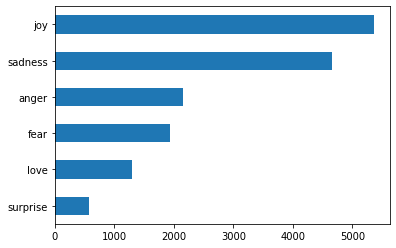

In [9]:
import matplotlib.pyplot as plt
train_df['lable_desc'].value_counts(ascending=True).plot.barh()

Checking the distribution of length of the text columns across categories

In [10]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))
train_df

,text,label,lable_desc,text_len
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


From the plot we see that for each emotion, most tweets are around 15 words long
and the longest tweets are well below DistilBERT’s maximum context size of 512 tokens

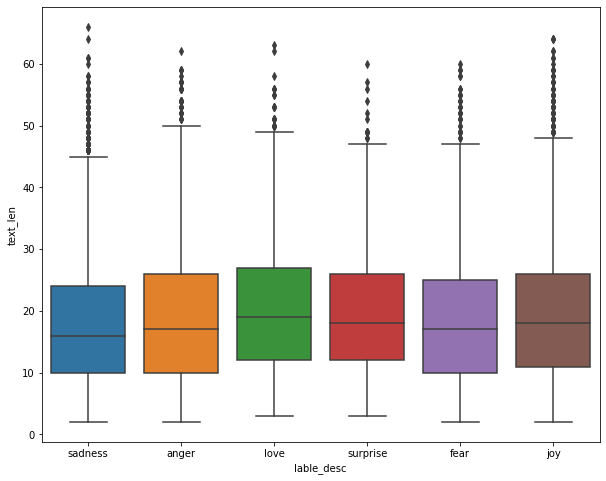

In [11]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.boxplot(x = train_df['lable_desc'], y = train_df['text_len'])
plt.show()

### Tokenization
In Huggingface, we can simply call respective checkpoint we would like to use, 'distilbert-base-uncased' in this case, and use AutoTokenizer to load the respective tokenizer. The Distilbert uses WordPiece tokenizer, which is one of the most commonly used subword tokenizer.

The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically
retrieve the model’s configuration, pretrained weights, or vocabulary from
the name of the checkpoint.

In [12]:
from transformers import AutoTokenizer
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Now let's check the tokenizer at work using an example text

In [13]:
encoded_ex = tokenizer("I like to solve NLP problems using transformers")
encoded_ex

{'input_ids': [101, 1045, 2066, 2000, 9611, 17953, 2361, 3471, 2478, 19081, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

We can observe three things here. First, some special [CLS] and [SEP] tokens have
been added to the start and end of the sequence. These tokens differ from model to
model, but their main role is to indicate the start and end of a sequence. Second, the
tokens have each been lowercased, which is a feature of this particular checkpoint.
Finally, we can see that “NLP” has been split into two tokens,
which makes sense since it is not a common word.

In [14]:
tokenizer.convert_ids_to_tokens(encoded_ex['input_ids'])

['[CLS]',
 'i',
 'like',
 'to',
 'solve',
 'nl',
 '##p',
 'problems',
 'using',
 'transformers',
 '[SEP]']

Checking the total vocabulary size

In [15]:
tokenizer.vocab_size

30522

model’s maximum context size

In [16]:
tokenizer.model_max_length

512

Tokenize the entire dataset

Processing function to tokenize:

This function applies the tokenizer to a batch of examples; padding=True will pad the
examples with zeros to the size of the longest one in a batch, and truncation=True
will truncate the examples to the model’s maximum context size

In [17]:
def tokenize(batch):
  return tokenizer(batch['text'],padding=True, truncation=True)

In [18]:
print(tokenize(emotion["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


* Here we can see the result of padding: the first element of input_ids is shorter than
the second, so zeros have been added to that element to make them the same length.
* Also note that in addition to returning the encoded tweets as input_ids, the tokenizer
returns a list of attention_mask arrays. This is because we do not want the
model to get confused by the additional padding tokens: the attention mask allows
the model to ignore the padded parts of the input.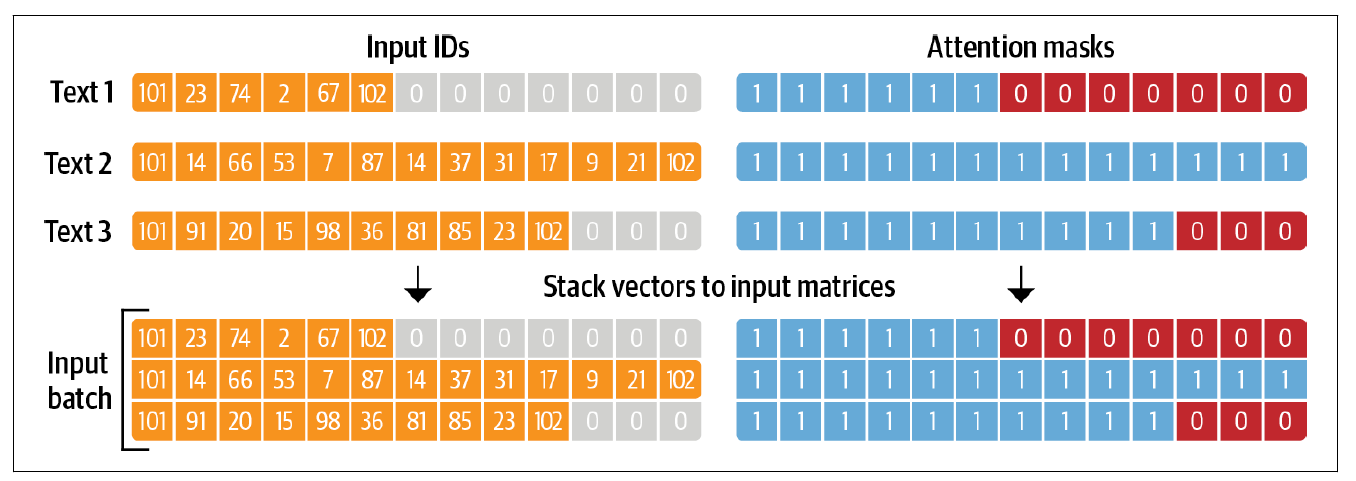

Once we’ve defined a processing function, we can apply it across all the splits in the
corpus in a single line of code:

In [19]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the map() method operates individually on every example in the corpus,
so setting batched=True will encode the tweets in batches. Because we’ve set
batch_size=None, our tokenize() function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally, and we can see that this operation has added new input_ids and
attention_mask columns to the dataset:

In [20]:
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

### Training a text classifier

models like DistilBERT are pretrained to predict masked
words in a sequence of text. However, we can’t use these language models directly for
text classification; we need to modify them slightly. To understand what modifications
are necessary, let’s take a look at the architecture of an encoder-based model like
DistilBERT,
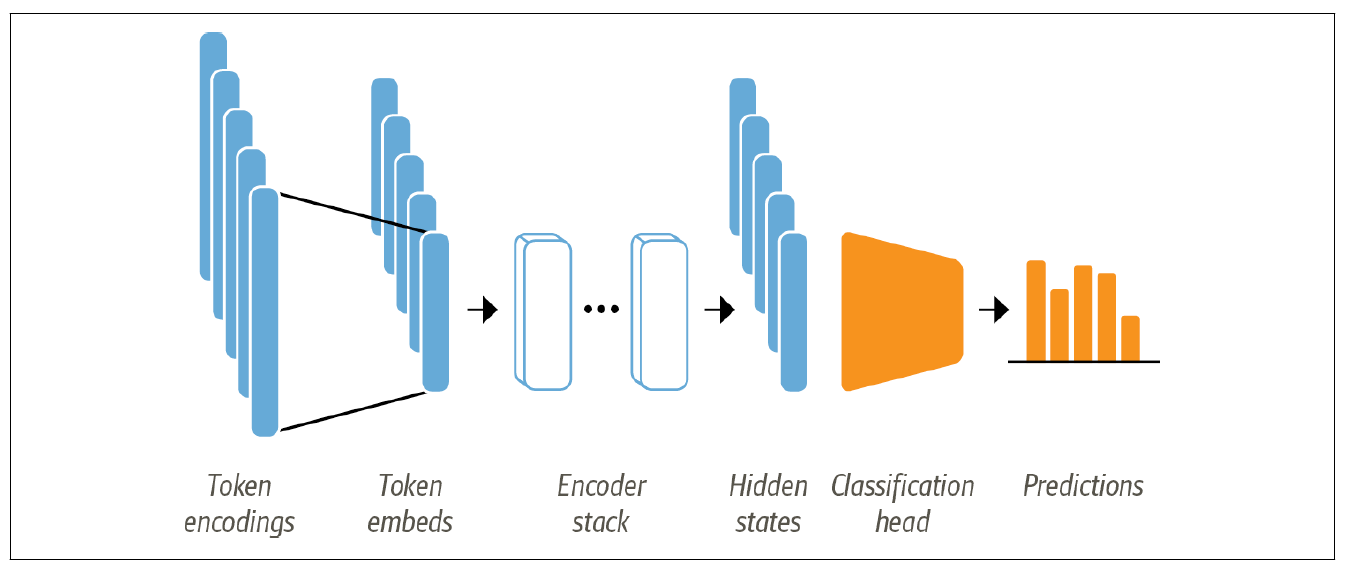

First, the text is tokenized and represented as one-hot vectors called token encodings.
The size of the tokenizer vocabulary determines the dimension of the token encodings,
and it usually consists of 20k–200k unique tokens. Next, these token encodings
are converted to token embeddings, which are vectors living in a lower-dimensional
space. The token embeddings are then passed through the encoder block layers to
yield a hidden state for each input token. For the pretraining objective of language
modeling,6 each hidden state is fed to a layer that predicts the masked input tokens.
For the classification task, we replace the language modeling layer with a classification
layer.

We have two options to train such a model on our Twitter dataset:
* Feature extraction : We use the hidden states as features and just train a classifier on them, without
modifying the pretrained model.
* Fine-tuning: We train the whole model end-to-end, which also updates the parameters of the
pretrained model.

#### Transformers as Feature Extractors
Using a transformer as a feature extractor is fairly simple. We
freeze the body’s weights during training and use the hidden states as features for the
classifier. The advantage of this approach is that we can quickly train a small or shallow
model. Such a model could be a neural classification layer or a method that does
not rely on gradients, such as a random forest. This method is especially convenient if
GPUs are unavailable, since the hidden states only need to be precomputed once.
In the feature-based approach, the DistilBERT model is frozen and just provides
features for a classifier

In [21]:
from transformers import AutoModel
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The AutoModel class converts the token encodings to embeddings, and then feeds
them through the encoder stack to return the hidden states. Let’s take a look at how
we can extract these states from our corpus.

In [22]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [23]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Here we’ve used the torch.no_grad() context manager to disable the automatic calculation
of the gradient. This is useful for inference since it reduces the memory footprint
of the computations

The
current model returns only one attribute, which is the last hidden state, so let’s examine
its shape:

In [24]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size,
n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
each of the 6 input tokens. For classification tasks, it is common practice to just use
the hidden state associated with the [CLS] token as the input feature. Since this token
appears at the start of each sequence, we can extract it by simply indexing into
outputs.last_hidden_state as follows:

In [25]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

let’s do the same for
the whole dataset by creating a new hidden_state column that stores all these vectors

In [26]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [27]:
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [28]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [29]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
import numpy as np
x_train = np.array(emotions_hidden["train"]['hidden_state'])
x_valid = np.array(emotions_hidden["validation"]['hidden_state'])
y_train = np.array(emotions_hidden["train"]['label'])
y_valid = np.array(emotions_hidden["validation"]['label'])
x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

####**Visualizing the training set:**

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll
use the powerful UMAP algorithm to project the vectors down to 2D. Since UMAP
works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a
MinMaxScaler and then use the UMAP implementation from the umap-learn library
to reduce the hidden states:

In [32]:
#!pip3 install umap-learn
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(x_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.608818,6.904025,0
1,-2.794882,6.692453,0
2,5.518193,3.261524,3
3,-2.230623,4.476887,2
4,-3.160641,4.589338,3


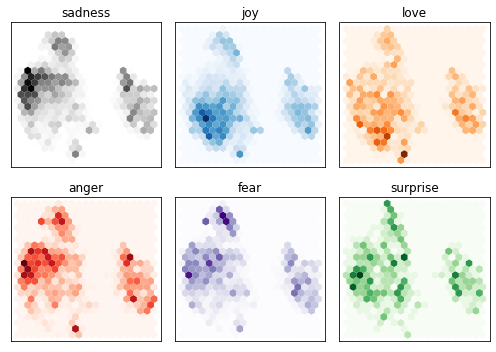

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotion["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: the negative feelings such as sadness,
anger, and fear all occupy similar regions with slightly varying distributions. On the
other hand, joy and love are well separated from the negative emotions and also
share a similar space. Finally, surprise is scattered all over the place. Although we
may have hoped for some separation, this is in no way guaranteed since the model
was not trained to know the difference between these emotions. It only learned them
implicitly by guessing the masked words in texts.

Fitting a Logistic regression model

In [35]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(x_train, y_train)
lr_clf.score(x_valid, y_valid)

0.633

Looking at the accuracy, it might appear that our model is just a bit better than random—
but since we are dealing with an unbalanced multiclass dataset, it’s actually significantly
better. We can examine whether our model is any good by comparing it
against a simple baseline. In Scikit-learn there is a DummyClassifier that can be used
to build a classifier with simple heuristics such as always choosing the majority class
or always drawing a random class. In this case the best-performing heuristic is to
always choose the most frequent class, which yields an accuracy of about 35%:

In [37]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

#### Plotting confusion matrix

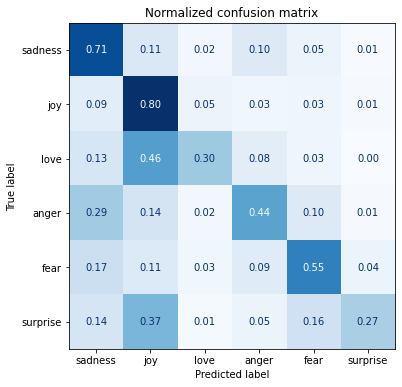

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
y_preds = lr_clf.predict(x_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Trying out Random Forest classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=250)
rf_clf.fit(x_train,y_train)
rf_clf.score(x_valid, y_valid)

0.527

#### Fine tuning transformers:
When using the fine-tuning approach the whole DistilBERT model is trained
along with the classification head
With the finetuning
approach we do not use the hidden states as fixed features, but instead train
them as shown in Figure below. This requires the classification head to be differentiable,
which is why this method usually uses a neural network for classification

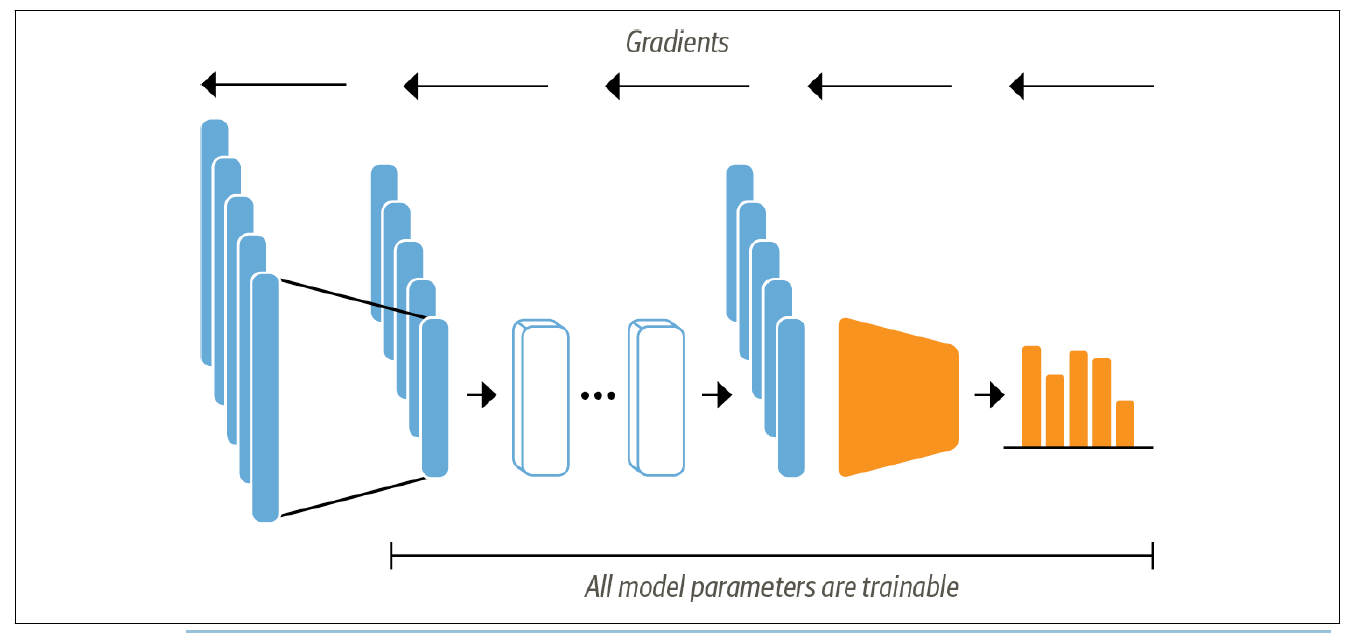

The first thing we need is a pretrained DistilBERT model like the one we used in the
feature-based approach. The only slight modification is that we use the AutoModelFor
SequenceClassification model instead of AutoModel. The difference is that the
AutoModelForSequenceClassification model has a classification head on top of the
pretrained model outputs, which can be easily trained with the base model. We just
need to specify how many labels the model has to predict (six in our case), since this
dictates the number of outputs the classification head has:

In [42]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(checkpoint, num_labels=num_labels)
.to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

To monitor metrics during training, we need to define a compute_metrics() function
for the Trainer. This function receives an EvalPrediction object (which is a named
tuple with predictions and label_ids attributes) and needs to return a dictionary
that maps each metric’s name to its value

In [43]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [47]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [45]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                num_train_epochs=2,
                learning_rate=2e-5,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                weight_decay=0.01,
                evaluation_strategy="epoch",
                disable_tqdm=False,
                logging_steps=logging_steps,
                push_to_hub=True,
                log_level="error")

In [48]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/raoswarup7/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.801400,0.310816,0.902000,0.898413
2,0.244600,0.217365,0.922000,0.922146


In [49]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [50]:
preds_output.metrics

{'test_loss': 0.21736490726470947,
 'test_accuracy': 0.922,
 'test_f1': 0.9221455870685494,
 'test_runtime': 4.3432,
 'test_samples_per_second': 460.487,
 'test_steps_per_second': 7.368}

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)

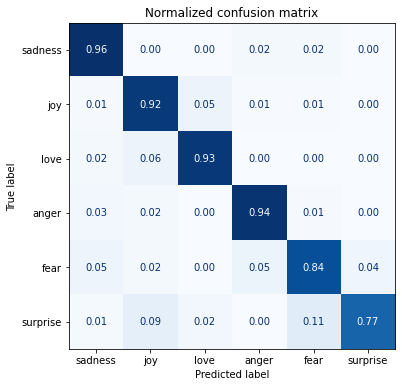

In [52]:
plot_confusion_matrix(y_preds, y_valid, labels)